## XGBoost: eXtreme Gradient Boosting
* Gradient Boosting algorithm also called GBM (Gradient Boosting Machine) including the learning rate
* Stochastic Gradient Boosting with sub-sampling at the row, column and column per split levels
* Extreme = because of engineering goal to make it super fast
* Regularized Gradient Boosting with both L1 and L2 regularization

**Nuances:**
* Labels need to be 0.. n-1 classes
* 2 APIs: xgb.train or xgb.XGBClassifier().fit - both APIs will have different parameter names (e.g. learning_rate or eta)
* Default parameter values: https://xgboost.readthedocs.io/en/latest/parameter.html


**References:**
* https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
* https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, f1_score, plot_confusion_matrix
from sklearn.datasets import dump_svmlight_file
from sklearn.preprocessing import LabelEncoder

In [2]:
pd.options.display.max_columns = None

---

### LIBSVM / SVMLIGHT file format:
* XGBoost currently supports two text formats for ingesting data: LIBSVM and CSV. [Link](https://xgboost.readthedocs.io/en/latest/tutorials/input_format.html)
* LIBSVM/SVMLIGHT format is a text-based format, with one sample per line. It does not store zero valued features hence is suitable for sparse dataset.

In [3]:
# help(dump_svmlight_file)

In [4]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=12)

dump_svmlight_file(X_train, y_train, 'dtrain.svm', zero_based=True)
dump_svmlight_file(X_test, y_test, 'dtest.svm', zero_based=True)
dtrain_svm = xgb.DMatrix('dtrain.svm')
dtest_svm = xgb.DMatrix('dtest.svm')

In [5]:
# X_train[1] = 0
# np.savetxt("temp.csv", X_train, delimiter=",")

---

## API option 1: TRAIN
* parameter names are not consistent with sklearn (eta, num_round etc.)
* requires DMatrix for both train and test
* eval_metric part of train()'s params

### Example - IRIS (because, why not!)

In [6]:
help(xgb.train)

Help on function train in module xgboost.training:

train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None)
    Train a booster with given parameters.
    
    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round: int
        Number of boosting iterations.
    evals: list of pairs (DMatrix, string)
        List of validation sets for which metrics will evaluated during training.
        Validation metrics will help us track the performance of the model.
    obj : function
        Customized objective function.
    feval : function
        Customized evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Validation metric needs to improve at least once in
        every **early_stopping_round

In [94]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
print(X_train.shape, X_test.shape)

(120, 4) (30, 4)


In [99]:
param = {
    'max_depth': 3,                 # the maximum depth of each tree
    'eta': 0.3,                     # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training (softmax = class, softprob = probability)
    'num_class': 3,                 # the number of classes that exist in this datset
    'eval_metric':'mlogloss',
#     'num_round':20
}                 

model1 = xgb.train(param, dtrain, num_boost_round=50)

preds = model1.predict(dtest)
print(preds[0:5])

best_preds = np.asarray([np.argmax(line) for line in preds])
print(best_preds[0:5])

[[9.9305832e-01 5.6063612e-03 1.3352670e-03]
 [7.6278631e-04 1.2921481e-03 9.9794501e-01]
 [9.9207652e-01 5.0041736e-03 2.9192679e-03]
 [3.3957248e-03 9.9417937e-01 2.4249505e-03]
 [1.5521281e-03 3.4555295e-03 9.9499232e-01]]
[0 2 0 1 2]


In [100]:
print(confusion_matrix(y_test, best_preds))

[[12  0  0]
 [ 0  8  1]
 [ 0  0  9]]


---

## API option 2: FIT (sklearn wrapper)
* DMatrix is not needed
* params as part of classifier instance
* eval_metric as part of classifier parameter or model.fit()

### Example - Palmer Penguins

In [10]:
help(xgb.XGBClassifier)
# eval_metric options: https://xgboost.readthedocs.io/en/stable/parameter.html

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective='binary:logistic', use_label_encoder=True, **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of boosting rounds.
 |      use_label_encoder : bool
 |          (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new
 |          code, we recommend that you set this parameter to False.
 |  
 |      max_depth : int
 |          Maximum tree depth for base learners.
 |      learning_rate : float
 |          Boosting learning rate (xgb's "eta")
 |      verbosity : int
 |          The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |      objective : string or callable
 |          Specify the learning task and the corresponding learning objective or
 |          a custom objective func

In [151]:
df = pd.read_csv('../../GitHub/Python-Data-Science/Data/penguins_size.csv')
df.dropna(inplace=True)   # reviewed in another notebook
df[df['sex']=='.']
df = df.drop(index=336)
# df.info()
display(df.head(2))

X = df.drop(columns='species')
y = df['species'].copy()
print(np.unique(y))

encoder = LabelEncoder()
y_ordinal = encoder.fit_transform(y)
print(np.unique(y_ordinal))

X_dummy = pd.get_dummies(X, drop_first=True)
display(X_dummy.head(2))

X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_ordinal, test_size=0.3, random_state=101)
print(X_train.shape, X_test.shape)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE


['Adelie' 'Chinstrap' 'Gentoo']
[0 1 2]


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1,1
1,39.5,17.4,186.0,3800.0,0,1,0


(233, 7) (100, 7)


#### Can handle missing values;

In [153]:
X_train.iloc[0,1] = np.NaN
X_train.head(2)

C:\Users\uditg\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [155]:
model2 = xgb.XGBClassifier(max_depth=3, learning_rate=0.3, use_label_encoder=False, eval_metric='merror')

In [156]:
model2

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='merror', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)

In [157]:
print(X_test.shape, y_test.shape)
val_test = [(X_test, y_test)]

model2.fit(X_train, y_train) #, eval_set=val_test)
y_pred = model2.predict(X_test)
print(confusion_matrix(y_test, y_pred))                 #Better than decision tree, same as RF & SVC

(100, 7) (100,)
[[39  1  0]
 [ 1 26  0]
 [ 0  0 33]]


C:\Users\uditg\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


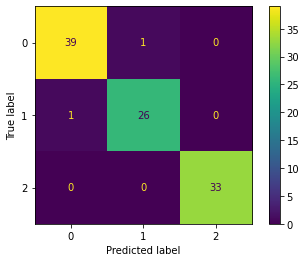

In [158]:
plot_confusion_matrix(model2, X_test, y_test);   #won't work with 1st API

---

### GridSearch for Tuning Hyperparameters
* Either through xgb.train or sklearn's GridSearchCV

In [20]:
# model = xgb.XGBClassifier(use_label_encoder=False)

param_grid = {'colsample_bynode':[0.5],
              'n_estimators':[100, 200],
              'max_depth': [3,6],
              'learning_rate': [0.02, 0.5, 0.1, 1]}

grid  = GridSearchCV(model2, param_grid)
grid.fit(X_train, y_train)

C:\Users\uditg\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='mlogloss',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=12,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                                     tree_method='exact',
   

In [21]:
grid.best_params_

{'colsample_bynode': 0.5,
 'learning_rate': 0.02,
 'max_depth': 3,
 'n_estimators': 100}

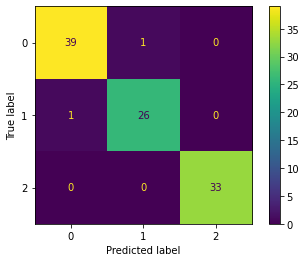

In [22]:
y_pred = grid.predict(X_test)
plot_confusion_matrix(grid, X_test, y_test);

---

## Example - Santander Customer Transaction Prediction
* https://www.kaggle.com/c/santander-customer-transaction-prediction/data?select=test.csv

### Data Load and Review

In [103]:
path = '../../GitHub/python-data-science/data/XGBoost/'
df_train = pd.read_csv(path+'santander_train.csv')   
df_test  = pd.read_csv(path+'santander_test.csv')   # no label

print(df_train.shape, df_test.shape)

df_train.head()
# ID_code = key
# target = 0/1
# var_0 to var_199 = numeric features

(200000, 202) (200000, 201)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [104]:
df_train['target'].value_counts()             
# 1:10 imbalance.. not extreme

0    179902
1     20098
Name: target, dtype: int64

In [105]:
df_train.describe()
# visual inspection suggests data is cleaned and no outliers; could do hist plots as well

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2000

In [106]:
missing = df_train.isna().sum()
missing[missing>0]
# no missing values

Series([], dtype: int64)

In [107]:
feat_columns = df_train.columns[2:]
X = df_train.loc[:, feat_columns]
y = df_train.loc[:, 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160000, 200), (40000, 200), (160000,), (40000,))

### Fitting Classifier & Evaluating Performance

In [108]:
model3 = xgb.XGBClassifier(learning_rate=0.1,
                           max_depth=5,                 
                           n_estimators=100,        # max # of trees; Number of boosting rounds
                           subsample=0.5,           # Subsample ratio of the training instanc
                           colsample_bytree=0.5,    # Subsample ratio of columns when constructing each tree
                           eval_metric='auc',       # Evaluation metrics for validation data - 'auc', 'error', 'logloss' etc.
                           verbosity=1,
                           use_label_encoder=False)

test_set = [(X_test, y_test)]                       # note 
print(X_test.shape, y_test.shape)

(40000, 200) (40000,)


In [109]:
model3.fit(X_train, y_train,
           early_stopping_rounds=10,                # stop if model performance doesn't change for 10 iterations
           eval_set = test_set,
           verbose = True)

[0]	validation_0-auc:0.63145
[1]	validation_0-auc:0.65483
[2]	validation_0-auc:0.67125
[3]	validation_0-auc:0.68133
[4]	validation_0-auc:0.69606
[5]	validation_0-auc:0.69658
[6]	validation_0-auc:0.69683
[7]	validation_0-auc:0.70017
[8]	validation_0-auc:0.70263
[9]	validation_0-auc:0.70939
[10]	validation_0-auc:0.71253
[11]	validation_0-auc:0.72071
[12]	validation_0-auc:0.72464
[13]	validation_0-auc:0.72687
[14]	validation_0-auc:0.73383
[15]	validation_0-auc:0.73625
[16]	validation_0-auc:0.74156
[17]	validation_0-auc:0.74391
[18]	validation_0-auc:0.74736
[19]	validation_0-auc:0.75296
[20]	validation_0-auc:0.75505
[21]	validation_0-auc:0.75928
[22]	validation_0-auc:0.76035
[23]	validation_0-auc:0.76316
[24]	validation_0-auc:0.76561
[25]	validation_0-auc:0.77000
[26]	validation_0-auc:0.77415
[27]	validation_0-auc:0.77494
[28]	validation_0-auc:0.77717
[29]	validation_0-auc:0.77898
[30]	validation_0-auc:0.78136
[31]	validation_0-auc:0.78339
[32]	validation_0-auc:0.78531
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [110]:
y_train_pred = model3.predict(X_train)
y_test_pred  = model3.predict(X_test)

y_train_prob = model3.predict_proba(X_train)[:,1]
y_test_prob  = model3.predict_proba(X_test)[:,1]

print('AUC score of Train: {:.4f} and Test: {:.4f}'.format(roc_auc_score(y_train, y_train_prob),
                                                           roc_auc_score(y_test, y_test_prob)))

print('F1 score of Train: {:.4f} and Test: {:.4f}'.format(f1_score(y_train, y_train_pred),
                                                          f1_score(y_test, y_test_pred)))

print('Train confusion matrix \n', confusion_matrix(y_train, y_train_pred), '\n')
print('Test confusion matrix \n', confusion_matrix(y_test, y_test_pred), '\n')

C:\Users\uditg\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


AUC score of Train: 0.9144 and Test: 0.8481
F1 score of Train: 0.2295 and Test: 0.1106
Train confusion matrix 
 [[143970     29]
 [ 13923   2078]] 

Test confusion matrix 
 [[35865    38]
 [ 3855   242]] 



In [ ]:
# with 500 runs
# precision = 8524/(8524+506)
# recall = 8524/(8524+7477)
# 2*precision*recall/(precision + recall) # 0.6810


# precision = 1286/(1286+381)
# recall = 1286/(1286+2811  )
# 2*precision*arecall/(precision + recall) # 0.4462